In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
import random

# Shifted Hill Functions

In [3]:
def shifted_hill_inhib(x, X0, n, lam):
    """
    Inhibitory shifted‐Hill:
      H_inhib(x; X0, n, λ) = λ + (1−λ)/(1 + (x/X0)^n ),  0 < λ < 1.
    """
    return lam + (1.0 - lam) / (1.0 + (x / X0)**n)

def shifted_hill_act(x, X0, n, lam):
    """
    Activating shifted‐Hill:
      H_act(x; X0, n, λ) = λ + (1−λ)/(1 + (x/X0)^n ),  λ > 1.
    """
    return lam + (1.0 - lam) / (1.0 + (x / X0)**n)

# Main simulation function definition

Does the following:
1) Defines equations, dynamic epigenetic thresholds
2) Noise addition
3) Euler Maruyama method for solving SDE 
4) Classifying trajectories into phenotypes based on final values
5) Returns final_states, phenotypes, A_traj, B_traj

In [176]:
def simulate_fixed_initial(args):
    """
    Simulate N_INIT trajectories for one α_AB value, always starting from
    the fixed initial state A(0)=A_INIT, B(0)=B_INIT.
    Returns:
      - final_states:    length N_INIT, each is (A_ss, B_ss)
      - phenotypes:      length N_INIT, each is 'A', 'B', or 'A/B'
      - A_traj:          array shape (N_INIT, TIME_STEPS)
      - B_traj:          array shape (N_INIT, TIME_STEPS)
    """
    alpha_AB, _ = args   # second element unused
    np.random.seed()     # ensure different RNG per call

    # Pre‐allocate arrays for all trajectories
    A_traj = np.zeros((N_INIT, TIME_STEPS))
    B_traj = np.zeros((N_INIT, TIME_STEPS))

    final_states = []
    phenotypes   = []

    # Constant thresholds for links that do not change:
    X0_BA = X0_BA_const
    X0_AA = X0_AA_basal
    X0_BB = X0_BB_basal

    for iteration in range(N_INIT):
        # 1) Initialize A and B for this replicate
        A = np.zeros(TIME_STEPS)
        B = np.zeros(TIME_STEPS)
        A[0] = A_INIT
        B[0] = B_INIT

        # 2) Initial epigenetic threshold for A⊣B
        X0_AB = X0_AB_basal

        # Store initial values
        A_traj[iteration, 0] = A[0]
        B_traj[iteration, 0] = B[0]

        # 3) Time‐stepping via Euler–Maruyama
        for t in range(TIME_STEPS - 1):
            # 3a) Epigenetic update for A⊣B:
            #     dX0_AB/dt = [(X0_AB_basal – X0_AB) – α_AB·A[t]] / BETA
            X0_AB_new = X0_AB
            X0_AB_new += DT * ((X0_AB_basal - X0_AB) - alpha_AB * A[t]) / BETA
            if X0_AB_new > 0:
                X0_AB=X0_AB_new

            # 3b) Compute all four shifted‐Hill terms:
            H_BA = shifted_hill_inhib(B[t], X0_BA, n_BA, lam_BA_const)
            H_AB = shifted_hill_inhib(A[t], X0_AB, n_AB, lam_AB_const)
            H_AA = shifted_hill_act  (A[t], X0_AA, n_AA, lam_AA)
            H_BB = shifted_hill_act  (B[t], X0_BB, n_BB, lam_BB)

            # 3c) Sample Multiplicative noise
            # mulnoiseA = np.random.normal(0.0, 1.0) * SIGMA * np.sqrt(A[t]) * sqrt_DT # multiplicative noise for A
            # mulnoiseB = np.random.normal(0.0, 1.0) * SIGMA * np.sqrt(B[t]) * sqrt_DT # multiplicative noise for B

            # 3c) Sample Additive Gaussian noise
            addnoiseA = np.random.normal(0.0, 1.0) * SIGMA * sqrt_DT # Additive noise for A
            addnoiseB = np.random.normal(0.0, 1.0) * SIGMA * sqrt_DT # Additive noise for B

            # 3d) Deterministic increments
            dA = gA * H_BA * H_AA - kA * A[t]
            dB = gB * H_AB * H_BB - kB * B[t]

            # 3e) Euler–Maruyama update (non‐negative)
            A[t+1] = max(A[t] + DT * dA + addnoiseA, 0.0) # decide which noise to use
            B[t+1] = max(B[t] + DT * dB + addnoiseB, 0.0) # decide which noise to use

            A_traj[iteration, t+1] = A[t+1]
            B_traj[iteration, t+1] = B[t+1]

        # 4) After TIME_STEPS, record final states (round to 3 decimals)
        valA = np.round(A[-1], 3)
        valB = np.round(B[-1], 3)
        final_states.append((valA, valB))

        # 5) Classify phenotype using direect comparison, no hybrid state counts”:
        
        if valA <= valB:
            phenotypes.append('B')
        if valB <= valA:
            phenotypes.append('A')

    return final_states, phenotypes, A_traj, B_traj

# Parameters

In [177]:
# Number of independent simulations (trajectories) per α_AB
N_INIT     = 100    # run 1000 replicates from the same initial condition

# Integration parameters
TIME_STEPS = 30000    # number of time‐steps
DT         = 0.1    # Δt for Euler–Maruyama
sqrt_DT = np.sqrt(DT)  # precompute noise for efficiency

# Production / Degradation rates
gA = 5.0   # production rate of A
gB = 5.0   # production rate of B
kA = 0.1   # degradation rate of A
kB = 0.1   # degradation rate of B

# Hill‐function parameters
#   Inhibitory fold‐changes (λ < 1)
lam_AB_const = 0.1   # λ_{A→B}  (A inhibits B)
lam_BA_const = 0.1   # λ_{B→A}  (B inhibits A)

#   Hill exponents (number of binding sites)
n_AB = 1  # Hill exponent for A⊣B
n_BA = 1  # Hill exponent for B⊣A

# Basal thresholds (half‐points) in molecule units
X0_AB_basal = 120.0   # basal threshold for A⊣B
X0_BA_const = 120.0   # threshold for B⊣A

# Self‐activation (λ > 1) parameters
lam_AA = 10.0  # A⟶A fold‐change
lam_BB = 10.0   # B⟶B fold‐change

n_AA = 4        # Hill exponent for A⟶A
n_BB = 4        # Hill exponent for B⟶B

X0_AA_basal = 80.0   # threshold for A⟶A
X0_BB_basal = 80.0   # threshold for B⟶B    

# Epigenetic feedback parameters (on A→B only)
#   dX0_AB/dt = [ (X0_AB_basal – X0_AB)  –  α_AB * A ] / BETA
BETA = 100.0       # β (relaxation factor ⇒ 100 hr)


SIGMA = 100.0 # noise scaling factor

# INITIAL CONDITION 

A_INIT = 500  # A(0) = 1 (very low)
B_INIT = 500  # B(0) = 999 (fairly high)

alpha_list = [0.00, 0.15, 0.35, 0.50] # α_AB values to simulate 

# Nullclines for Model 

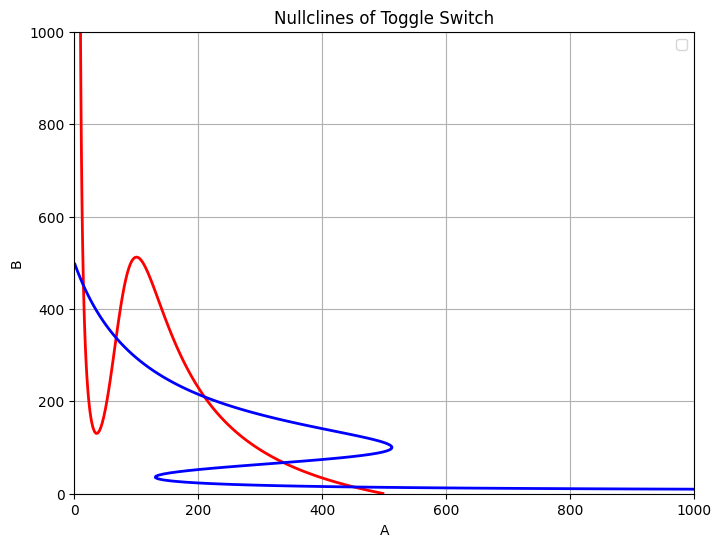

In [158]:
def dA_dt(A, B):
    return gA * shifted_hill_act(A, X0_AA_basal, n_AA, lam_AA) * shifted_hill_inhib(B, X0_BA_const, n_BA, lam_BA_const) - kA * A

def dB_dt(A, B):
    return gB * shifted_hill_act(B, X0_BB_basal, n_BB, lam_BB) * shifted_hill_inhib(A, X0_AB_basal, n_AB, lam_AB_const) - kB * B

A_vals = np.linspace(0, 1000, 400)
B_vals = np.linspace(0, 1000, 400)
A_mesh, B_mesh = np.meshgrid(A_vals, B_vals)

dA_vals = dA_dt(A_mesh, B_mesh)
dB_vals = dB_dt(A_mesh, B_mesh)

plt.figure(figsize=(8, 6))
plt.contour(A_mesh, B_mesh, dA_vals, levels=[0], colors='r', linewidths=2, linestyles='-')
plt.contour(A_mesh, B_mesh, dB_vals, levels=[0], colors='b', linewidths=2, linestyles='-')
plt.xlabel('A')
plt.ylabel('B')
plt.title('Nullclines of Toggle Switch')
plt.legend(['A-nullcline (red)', 'B-nullcline (blue dashed)'])
plt.grid(True)
plt.show()

# Running the Simulation

In [178]:

# Pre‐allocate for summary statistics
fracA_list = []    # fraction of “A‐dominant” phenotypes
meanA_list = []    # mean of A_ss across replicates
stdA_list  = []    # std of A_ss across replicates
fracB_list = []    # fraction of “B‐dominant” phenotypes
meanB_list = []    # mean of B_ss across replicates
stdB_list  = []    # std of B_ss across replicates

# For storing all A_ss per α_AB
full_A_ss = {}     # { alpha_AB : [list of N_INIT A_ss values] }
full_B_ss = {}     # { alpha_AB : [list of N_INIT B_ss values] }

M_dummy = None
A_alpha_traj = {}
B_alpha_traj = {}

# Run simulations for each alpha_val
for alpha_val in alpha_list:
    final_states, phenotypes, A_traj, B_traj = simulate_fixed_initial((alpha_val, M_dummy))
    A_alpha_traj[alpha_val] = A_traj
    B_alpha_traj[alpha_val] = B_traj

    # Unravel steady states
    A_values = [a_ss for (a_ss, b_ss) in final_states]
    B_values = [b_ss for (a_ss, b_ss) in final_states]
    full_A_ss[alpha_val] = A_values
    full_B_ss[alpha_val] = B_values

    # Compute fraction of “A‐dominant” (count only 'A' vs 'B')
    count_A     = sum(1 for ph in phenotypes if ph == 'A')
    count_B     = sum(1 for ph in phenotypes if ph == 'B')
    count_total = sum(1 for ph in phenotypes if ph in ['A', 'B'])
    fracA = (count_A / count_total) if (count_total > 0) else 0.0
    fracB = (count_B / count_total) if (count_total > 0) else 0.0
    fracA_list.append(fracA)
    fracB_list.append(fracB)

    meanA_list.append(np.mean(A_values))
    stdA_list.append(np.std(A_values))
    meanB_list.append(np.mean(B_values))
    stdB_list.append(np.std(B_values))

# Converting lists to numpy arrays for faster calling
alpha_arr = np.array(alpha_list)
fracA_arr = np.array(fracA_list)
fracB_arr = np.array(fracB_list)
meanA_arr = np.array(meanA_list)
stdA_arr  = np.array(stdA_list)
meanB_arr = np.array(meanB_list)
stdB_arr  = np.array(stdB_list)


# Fraction of A-Dominant & B-Dominant states vs alpha

Counts out of all the independent runs for each alpha value, number of final states resulting in A or B phenotype. Fraction of each phenotype is then calculated. 

For example: count_A / count_total

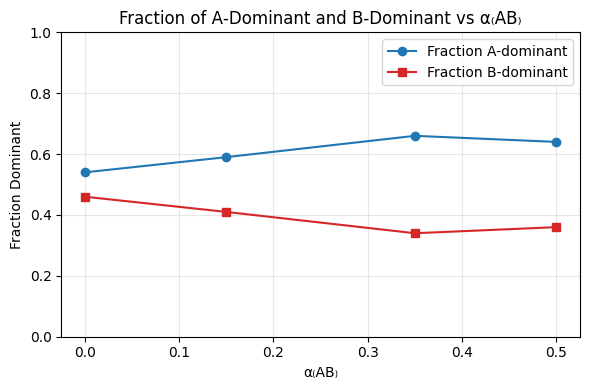

In [179]:
plt.figure(figsize=(6, 4))
plt.plot(alpha_arr, fracA_arr, marker='o', color='tab:blue', linestyle='-', label='Fraction A-dominant')
plt.plot(alpha_arr, fracB_arr, marker='s', color='tab:red', linestyle='-', label='Fraction B-dominant')
plt.title("Fraction of A‐Dominant and B‐Dominant vs α₍AB₎")
plt.xlabel("α₍AB₎")
plt.ylabel("Fraction Dominant")
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

# Mean Final State Expression Levels vs Alpha

Plots Mean & Std. Deviation of final state expression levels of all independent runs per alpha value.

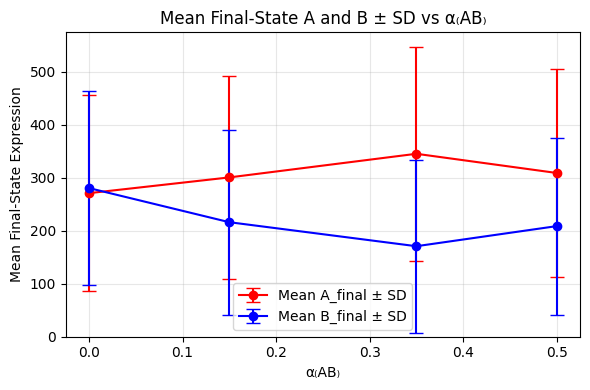

In [180]:
plt.figure(figsize=(6, 4))
plt.errorbar(alpha_arr, meanA_arr, yerr=stdA_arr, marker='o', color='red',
            linestyle='-', capsize=5, label="Mean A_final ± SD")
plt.errorbar(alpha_arr, meanB_arr, yerr=stdB_arr, marker='o', color='blue',
            linestyle='-', capsize=5, label="Mean B_final ± SD")
plt.title("Mean Final-State A and B ± SD vs α₍AB₎")
plt.xlabel("α₍AB₎")
plt.ylabel("Mean Final-State Expression")
plt.ylim(bottom=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

# Randomly picked Trajectory plots
2 randomly selected idependent runs (each has a A traj & B traj) have been plotted for each of the alpha value conditions to give us an idea about the effect of noise and initial conditions on the dynamics of this model. 

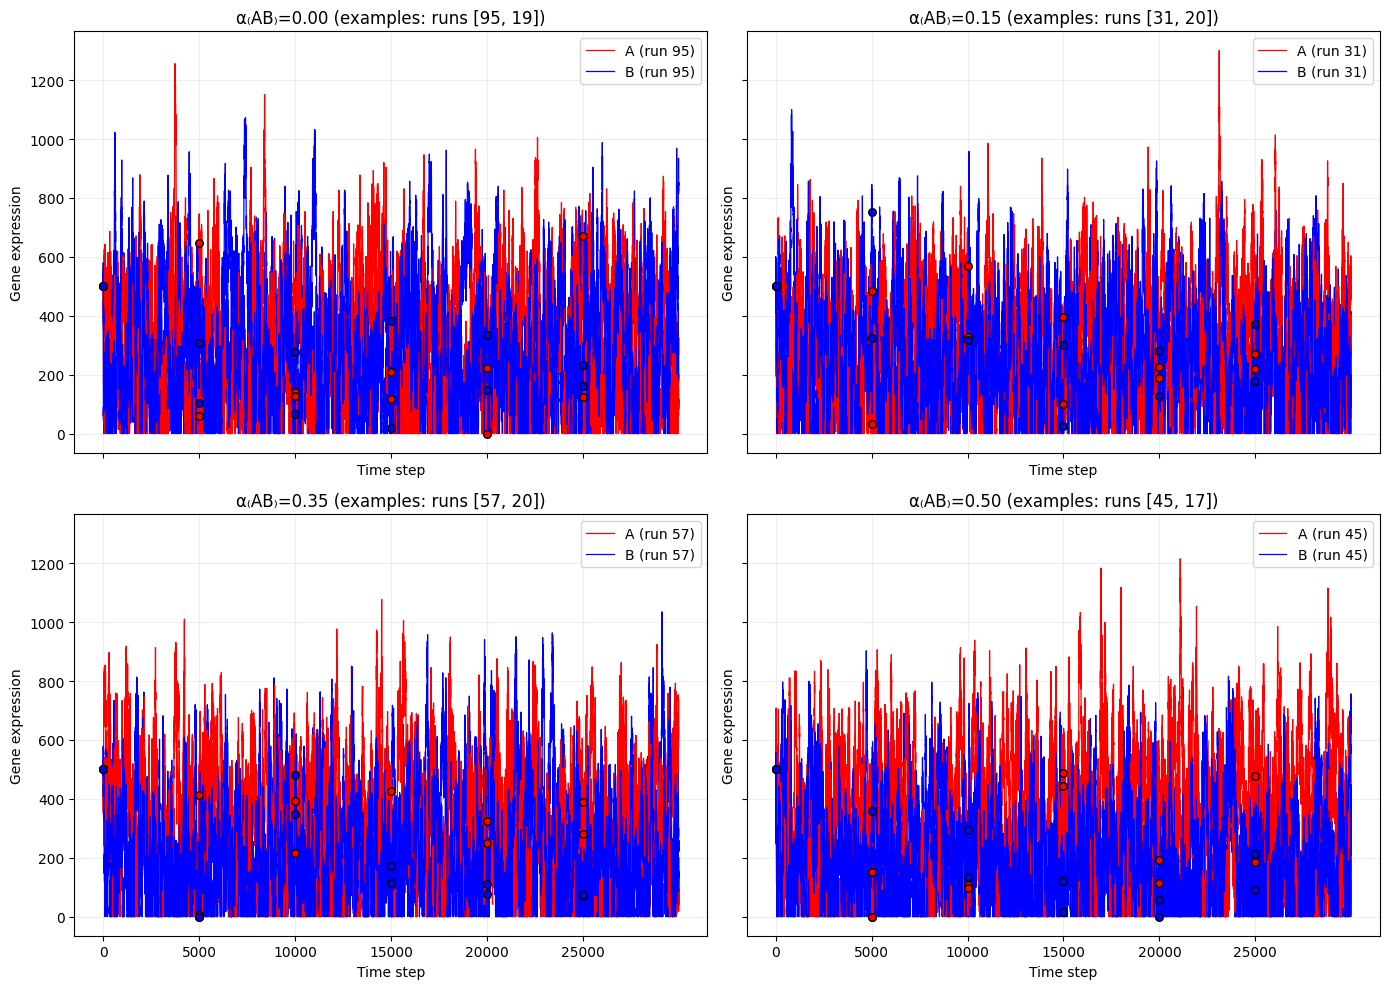

In [181]:

time_steps = np.arange(TIME_STEPS)
xticks = np.arange(0, TIME_STEPS-1, 5000)

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

for ax, alpha_val in zip(axs.flat, alpha_list):
    A_trajs = A_alpha_traj[alpha_val]  # shape (N_INIT, TIME_STEPS)
    B_trajs = B_alpha_traj[alpha_val]

    # --- Randomly select two indices (runs) ---
    if N_INIT < 2:
        chosen_idxs = list(range(N_INIT))
    else:
        chosen_idxs = random.sample(range(N_INIT), 2)

    for idx in chosen_idxs:
        ax.plot(time_steps, A_trajs[idx], color='red', lw=0.9, label="A (run %d)" % idx if idx == chosen_idxs[0] else None)
        ax.plot(time_steps, B_trajs[idx], color='blue', lw=0.9, label="B (run %d)" % idx if idx == chosen_idxs[0] else None)

    # --- Mark every 5000 steps ---
    for idx in chosen_idxs:
        ax.scatter(xticks, A_trajs[idx][xticks], color='red', s=30, marker='o', edgecolor='k', zorder=3)
        ax.scatter(xticks, B_trajs[idx][xticks], color='blue', s=30, marker='o', edgecolor='k', zorder=3)

    ax.set_title(f"α₍AB₎={alpha_val:.2f} (examples: runs {chosen_idxs})")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Gene expression")
    ax.set_xticks(xticks)
    ax.grid(alpha=0.2)
    ax.legend()
plt.tight_layout()
plt.show()